In [28]:
# -*- coding: utf-8 -*-

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



In [30]:
game_threshold = 4 # minimum number of games to be in the dataset as a player
test_size = 0.01 # % of the dataset is used for testing
ModelHasBot = True #  if True, the bot is considered as a player - to consider bot statistics in games 2vs3 or 3vs4
hasMapWeight = False  # if True, the map weight is used in the model
timeStart ='2023-06-18' # start date of the dataset
timeStart=''
present_players = [ 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',   'Сеньор', 'Юран']


# make a set out of the list to remove duplicates
present_players = list(set(present_players))
if len(present_players) > 8:
    print('Too many players')
    exit()

# 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей', 'Савва', 'Сеньор', 'Юран'

# Data preprocessing

In [31]:
# dataset = pd.read_csv('data.csv') 
dataset = pd.read_csv('labelled_data.csv') 
columnsPlayers = ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
columnsTeam1 = ["Player1","Player2","Player3","Player4"]
columnsTeam2 = ["Player5","Player6","Player7","Player8"]

In [32]:
dataset["Map"] = dataset["Map"].str.lower() # convert all maps to lower case
dataset['Date'] = pd.to_datetime(dataset['Date'],format='%d.%m.%Y') # convert date to datetime
dataset=dataset.drop_duplicates(subset=['Date','Map']) # drop duplicates with same date and map

dataset.drop(columns=['link','Recorder','vs'],   inplace=True) # drop columns that are not needed
dataset.dropna(subset=['TeamWon'], inplace=True) # drop entries with no map
dataset.to_csv('new_data.csv',index=False) # save the new dataset
#  drop entries which were played before the start date
if timeStart != '':
    dataset = dataset[dataset['Date'] >= timeStart]



### Add column with number of maps in each campaign

In [33]:
map_weights = {
'ливень':5,
'кровавая жатва':5, 
'переход':3,
'мрачный карнавал':5,
'холодный ручей':4,
'похоронный звон':5,
'приход':5,
'смерть в воздухе':5,
'нет милосердию':5,
'вымерший центр':4,
'болотная лихорадка':4,
'последний рубеж':2,
'жертва':3,
'роковой полет':5}

def map_weight(map):
    return map_weights[map]

dataset["Map_weight"] = dataset["Map"].apply(map_weight)
dataset["Map_weight"] = dataset["Map_weight"]/ dataset["Map_weight"].max()# scale weight
if not hasMapWeight:
    dataset["Map_weight"] =np.ones(len(dataset)) # remove map weight
dataset.Map.value_counts()

Map
смерть в воздухе      13
нет милосердию        13
переход               12
мрачный карнавал      12
приход                11
похоронный звон       10
ливень                 9
кровавая жатва         9
вымерший центр         9
холодный ручей         7
жертва                 6
последний рубеж        4
болотная лихорадка     4
роковой полет          3
Name: count, dtype: int64

#### Unique players and cleaning those with small statistics

In [34]:
# unique players from all 8 columns ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
players = np.unique(dataset[columnsPlayers].values)
players = pd.DataFrame(players, columns=["Player"])
# filter players that have played more than 'game_threshold' games
players = players[players["Player"].map(dataset[columnsPlayers].stack().value_counts()) >= game_threshold]
players = players["Player"].values

# remove rows with players not in the list
dataset = dataset[dataset[columnsPlayers].isin(players).all(axis=1)]

if not ModelHasBot: # remove bot from the list of players
    players = players[players != 'Бот']
players

array(['Бот', 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',
       'Ондрей', 'Савва', 'Сеньор', 'Юран'], dtype=object)

In [35]:
remove_players = ['Ондрей/Джун', 'Ондрей/Сеньор', 'Марина']
# drop rows with some chosen remove_players in any of the 8 columns
def drop_players(row):
    for player in remove_players:
        if player in row.values:
            return False
    return True
dataset.drop(dataset[~dataset.apply(drop_players, axis=1)].index, inplace=True)
players = np.unique(dataset[["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]].values)

players

array(['Бот', 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',
       'Ондрей', 'Савва', 'Сеньор', 'Юран'], dtype=object)

In [36]:
#  add data with swapped players to lower values of absent players
swapped = dataset.copy()
swapped[columnsTeam1+columnsTeam2] = swapped[columnsTeam2+columnsTeam1]
swapped['TeamWon'] = 3 - swapped['TeamWon']
swapped

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,TeamWon,Map_weight
0,2024-03-09,ливень,Сеньор,Савва,Данил,Бот,Ден,Гриша,Ондрей,Юран,2.0,1.0
1,2024-03-03,кровавая жатва,Гриша,Миша,Ден,Бот,Данил,Вадим,Сеньор,Савва,1.0,1.0
2,2024-03-03,переход,Ден,Данил,Савва,Миша,Вадим,Сеньор,Юран,Гриша,1.0,1.0
3,2024-03-02,мрачный карнавал,Вадим,Миша,Ваня,Бот,Данил,Гриша,Сеньор,Савва,1.0,1.0
4,2024-02-25,похоронный звон,Данил,Ваня,Савва,Вадим,Юран,Гриша,Сеньор,Ден,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2022-12-10,мрачный карнавал,Джун,Миша,Данил,Бот,Сеньор,Ден,Гриша,Ондрей,1.0,1.0
118,2022-11-11,кровавая жатва,Ондрей,Миша,Гриша,Бот,Ден,Сеньор,Джун,Ваня,2.0,1.0
119,2022-11-11,похоронный звон,Вадим,Ден,Ваня,Бот,Сеньор,Миша,Гриша,Бот,1.0,1.0
120,2022-11-03,кровавая жатва,Джун,Вадим,Ден,Бот,Миша,Ондрей,Данил,Бот,1.0,1.0


In [37]:
dataset = pd.concat([dataset, swapped])
 

In [38]:
# Players from "Team 1" are Player1, Player2, Player3, Player4
# Players from "Team 2" are Player5, Player6, Player7, Player8
# TeamWon column is the team that won the game
#  assign to player in which team he was

from keras.utils import to_categorical

for player in players:
    # make default value 0
    dataset[player] = 0
    dataset.loc[(dataset['Player1'] == player) | (dataset['Player2'] == player) | (dataset['Player3'] == player) | (dataset['Player4'] == player), player] = 1
    dataset.loc[(dataset['Player5'] == player) | (dataset['Player6'] == player) | (dataset['Player7'] == player) | (dataset['Player8'] == player), player] = 2
    if player=="Бот":
        dataset.loc[(dataset['Player4'] == "Бот") & (dataset['Player8'] == "Бот"), 'Бот'] = 0 # remove bot from statistics of 3 vs 3
    # now make it categorical
    
    labels=to_categorical(dataset[player])
    # make labels as pandas dataframe
    labels = pd.DataFrame(labels, columns=[player+"_abcent", player+"_team1", player+"_team2"])
    labels.drop(columns=[player+"_abcent"], inplace=True)

    # add to dataset
    dataset.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)

    dataset = pd.concat([dataset, labels], axis=1)
    # drop original column
    dataset.drop(columns=[player], inplace=True)

In [39]:
dataset.shape

(232, 36)

In [40]:
dataset

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,TeamWon,Map_weight,Бот_team1,Бот_team2,Вадим_team1,Вадим_team2,Ваня_team1,Ваня_team2,Гриша_team1,Гриша_team2,Данил_team1,Данил_team2,Ден_team1,Ден_team2,Джун_team1,Джун_team2,Миша_team1,Миша_team2,Ондрей_team1,Ондрей_team2,Савва_team1,Савва_team2,Сеньор_team1,Сеньор_team2,Юран_team1,Юран_team2
0,2024-03-09,ливень,Ден,Гриша,Ондрей,Юран,Сеньор,Савва,Данил,Бот,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2024-03-03,кровавая жатва,Данил,Вадим,Сеньор,Савва,Гриша,Миша,Ден,Бот,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2024-03-03,переход,Вадим,Сеньор,Юран,Гриша,Ден,Данил,Савва,Миша,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-03-02,мрачный карнавал,Данил,Гриша,Сеньор,Савва,Вадим,Миша,Ваня,Бот,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2024-02-25,похоронный звон,Юран,Гриша,Сеньор,Ден,Данил,Ваня,Савва,Вадим,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-12-10,мрачный карнавал,Джун,Миша,Данил,Бот,Сеньор,Ден,Гриша,Ондрей,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
228,2022-11-11,кровавая жатва,Ондрей,Миша,Гриша,Бот,Ден,Сеньор,Джун,Ваня,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
229,2022-11-11,похоронный звон,Вадим,Ден,Ваня,Бот,Сеньор,Миша,Гриша,Бот,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
230,2022-11-03,кровавая жатва,Джун,Вадим,Ден,Бот,Миша,Ондрей,Данил,Бот,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# # plot individual player winrate during some period
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8,5))
# slice_duration_days = 20


# def plot_player_winrate(player):
#     player_data = dataset[dataset[player] != 0]
#     player_data = player_data.sort_values(by='Date')
#     player_data = player_data.set_index('Date')

#     player_data["win"] = player_data['TeamWon'] == player_data[player]
#     player_data["win"] = player_data["win"].replace({player:1,0:0})
#     player_data["win"] = player_data["win"].fillna(0)
#     player_data["win"] = player_data["win"].astype(int)

#     player_data["winrate"] = player_data["win"].rolling(f'{slice_duration_days}D').mean()


#     # plot not every entry but only every 10th and skip first 5 entries
        
#     player_data = player_data.iloc[5::1, :]
#     player_data = player_data.reset_index()
#     player_data = player_data.dropna()
#     sns.lineplot(x=player_data['Date'], y=player_data['winrate'], label=player)

# for player in players:
#     plot_player_winrate(player)

# plt.show()




## Train the model

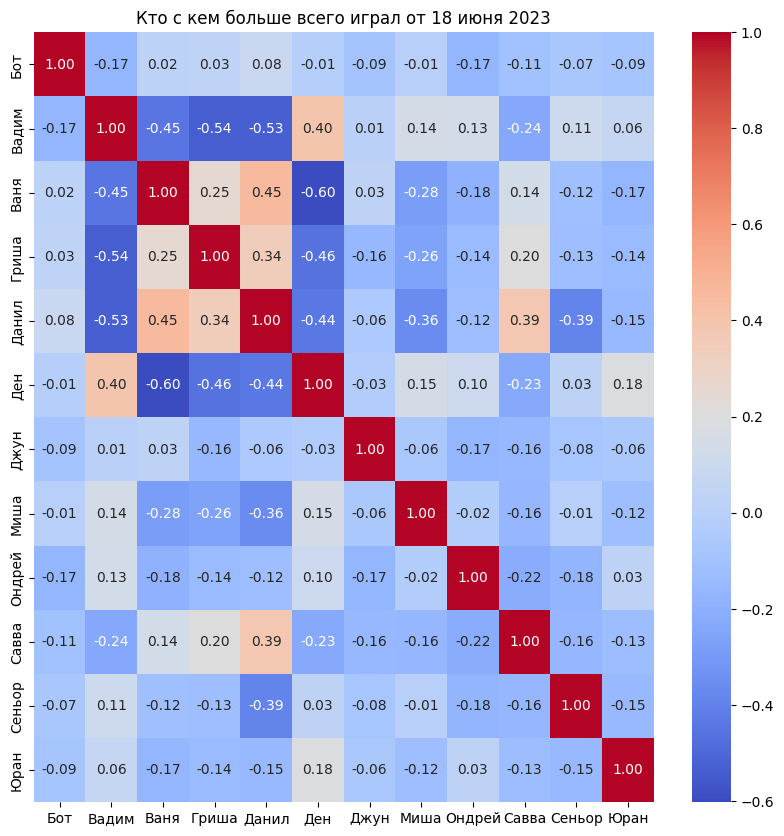

In [42]:
# plot  correlation between  players who won together
players_1team =  [player+"_team1" for player in players]
#  correlation between  players who won together
correlation = dataset[players_1team].corr()
# remove _team1 from the column names
correlation.columns = [col[:-6] for col in correlation.columns]
correlation.index = [col[:-6] for col in correlation.index]

plt.figure(figsize=(10, 10))
#  plot correlation matrix wit z title
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")

plt.title('Кто с кем больше всего играл от 18 июня 2023')


plt.show()

In [43]:
input_data_players = [player+"_team1" for player in players] + [player+"_team2" for player in players]
# add "TeamWon" to input_data_players 
columns = input_data_players.copy()
columns.append("TeamWon")
columns.append("Map_weight")

dataset = dataset[columns]
print(dataset.shape)
dataset = dataset.drop_duplicates()
print(dataset.shape)

(232, 26)
(198, 26)


In [44]:
# split the dataset into train and test
train, test = train_test_split(dataset,  test_size=test_size)

# select the columns to predict
y_train = train['TeamWon']-1  # 0 or 1
y_test = test['TeamWon']-1 # 0 or 1

# select the columns to train the model
X_train = train[input_data_players]
w_train = train["Map_weight"]
X_test = test[input_data_players]
w_test = test["Map_weight"]

In [45]:
#  create a model
model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(len(input_data_players),), activation='relu'),
    keras.layers.Dense(100, activation='relu'), 
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

from keras.callbacks import EarlyStopping 
# Early stopping criteria to avoid overtraining
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)


# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              # weighted_metrics=['accuracy']
              )
# train the model
model.fit(X_train,
          y_train, 
          # sample_weight=w_train,
          validation_split=0.1, 
          callbacks=[earlystopping],
          epochs=100)
# test the model
print ("")
print ("Test")
result = model.evaluate(X_test, y_test)#), sample_weight=w_test)


Epoch 1/100
6/6 [==============================] - 1s 32ms/step - loss: 0.6854 - accuracy: 0.5398 - val_loss: 0.6681 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6510 - accuracy: 0.6591 - val_loss: 0.6437 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6282 - accuracy: 0.6875 - val_loss: 0.6319 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6052 - accuracy: 0.7045 - val_loss: 0.6260 - val_accuracy: 0.5500
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5854 - accuracy: 0.7273 - val_loss: 0.6267 - val_accuracy: 0.5500
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5675 - accuracy: 0.7443 - val_loss: 0.6294 - val_accuracy: 0.5500
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5495 - accuracy: 0.7500 - val_loss: 0.6374 - val_accuracy: 0.7000
Epoch 8/100
6/6 [====

In [46]:
# save model 
model.save('model.keras')

In [47]:
input_data_players

['Бот_team1',
 'Вадим_team1',
 'Ваня_team1',
 'Гриша_team1',
 'Данил_team1',
 'Ден_team1',
 'Джун_team1',
 'Миша_team1',
 'Ондрей_team1',
 'Савва_team1',
 'Сеньор_team1',
 'Юран_team1',
 'Бот_team2',
 'Вадим_team2',
 'Ваня_team2',
 'Гриша_team2',
 'Данил_team2',
 'Ден_team2',
 'Джун_team2',
 'Миша_team2',
 'Ондрей_team2',
 'Савва_team2',
 'Сеньор_team2',
 'Юран_team2']

In [48]:
def nn_output(present_players):
    all_results = []
    # add bots to the present players if there are less than 8 players
    while len(present_players) < 8:
        present_players = present_players + ["Бот"]
        
    print ('present_players are', present_players)

    for i in range(0, len(present_players)):
        for j in range(i+1, len(present_players)):
            for k in range(j+1, len(present_players)):
                for l in range(k+1, len(present_players)):
                                    team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                                    # subtract team 1 player form list of present players, "Бот" can be used many times
                                    team2 = [x for x in present_players if x not in team1]
                                    # if team 2 has less than 4 players, add "Бот" to team 2
                                    while len(team2) < 4:
                                        team2 = team2 + ["Бот"]
                                    # create a row with the players
                                    row = np.zeros(len(input_data_players))
                                    for player in team1:
                                        row[input_data_players.index(player+"_team1")] = 1
                                    for player in team2:
                                        row[input_data_players.index(player+"_team2")] = 1
                                    # if present_players.count("Бот") == 2:
                                    #     row[input_data_players.index("Бот_team1")]= 0
                                    #     row[input_data_players.index("Бот_team2")]= 0
                                    
                                    row = row.reshape(1, -1)

                                    # predict the result
                                    result = model.predict(row, verbose=0)
                                    all_results.append((team1, team2, result))
    # sort the results
    all_results.sort(key=lambda x: x[2], reverse=True)
    return all_results

all_results = nn_output(present_players)


present_players are ['Сеньор', 'Ден', 'Миша', 'Гриша', 'Юран', 'Ваня', 'Джун', 'Данил']


In [49]:
# print the results
print ("              Team 1                vs                Team 2             : which team is closer to win")
for i in range(0, len(all_results)):
    print(all_results[i][0], "vs", all_results[i][1], ":", round(1+all_results[i][2][0][0],3))

              Team 1                vs                Team 2             : which team is closer to win
['Сеньор', 'Миша', 'Юран', 'Джун'] vs ['Ден', 'Гриша', 'Ваня', 'Данил'] : 1.613
['Ден', 'Миша', 'Юран', 'Джун'] vs ['Сеньор', 'Гриша', 'Ваня', 'Данил'] : 1.576
['Сеньор', 'Ден', 'Миша', 'Юран'] vs ['Гриша', 'Ваня', 'Джун', 'Данил'] : 1.574
['Сеньор', 'Гриша', 'Юран', 'Джун'] vs ['Ден', 'Миша', 'Ваня', 'Данил'] : 1.57
['Сеньор', 'Миша', 'Гриша', 'Юран'] vs ['Ден', 'Ваня', 'Джун', 'Данил'] : 1.569
['Сеньор', 'Ден', 'Юран', 'Джун'] vs ['Миша', 'Гриша', 'Ваня', 'Данил'] : 1.554
['Сеньор', 'Ден', 'Гриша', 'Юран'] vs ['Миша', 'Ваня', 'Джун', 'Данил'] : 1.543
['Сеньор', 'Юран', 'Ваня', 'Джун'] vs ['Ден', 'Миша', 'Гриша', 'Данил'] : 1.538
['Сеньор', 'Гриша', 'Юран', 'Ваня'] vs ['Ден', 'Миша', 'Джун', 'Данил'] : 1.537
['Сеньор', 'Ден', 'Юран', 'Ваня'] vs ['Миша', 'Гриша', 'Джун', 'Данил'] : 1.53
['Ден', 'Миша', 'Гриша', 'Юран'] vs ['Сеньор', 'Ваня', 'Джун', 'Данил'] : 1.523
['Сеньор', 'Миша', 

In [50]:
#  take the middle of the list
middle_nn = len(all_results) // 2
print ("best team by median:")
print(all_results[middle_nn][0], "vs", all_results[middle_nn][1], "with output=", all_results[middle_nn][2][0][0])

#second best team
print ("second best team by median:")
print(all_results[middle_nn-1][0], "vs", all_results[middle_nn-1][1], "with output=", all_results[middle_nn-1][2][0][0])



best team by median:
['Сеньор', 'Ден', 'Гриша', 'Данил'] vs ['Миша', 'Юран', 'Ваня', 'Джун'] with output= 0.43072528
second best team by median:
['Ден', 'Гриша', 'Юран', 'Ваня'] vs ['Сеньор', 'Миша', 'Джун', 'Данил'] with output= 0.43702766


In [51]:
# take closest to 50% result
closest = min(all_results, key=lambda x: abs(x[2] - 0.5))
print ("best team by model 50% result:")
print(closest[0], "vs", closest[1], "with output=", closest[2][0][0])

best team by model 50% result:
['Сеньор', 'Миша', 'Юран', 'Ваня'] vs ['Ден', 'Гриша', 'Джун', 'Данил'] with output= 0.497083


In [52]:
# make the list of players from table above
old_method_dataset = pd.DataFrame({
    "Player": ["Сеньор", "Гриша", "Миша", "Ваня", "Бот", "Джун", "Данил", "Вадим", "Ондрей", "Юран", "Ден", "Савва"],
    "Games":  [      21,      22,     19,     18,     6,      8,      16,      24,       12,     10,    18,      10],
    "Wins":   [      14,      14,     11,     10,     3,      4,       8,      10,        5,      4,     6,       3]
})

old_method_dataset["Winrate"] = old_method_dataset["Wins"] / old_method_dataset["Games"]
old_method_dataset = old_method_dataset.sort_values(by="Winrate", ascending=False)
old_method_dataset

,Player,Games,Wins,Winrate
0,Сеньор,21,14,0.666667
1,Гриша,22,14,0.636364
2,Миша,19,11,0.578947
3,Ваня,18,10,0.555556
4,Бот,6,3,0.500000
5,Джун,8,4,0.500000
6,Данил,16,8,0.500000
7,Вадим,24,10,0.416667
8,Ондрей,12,5,0.416667
9,Юран,10,4,0.400000


In [53]:
# based on present players and winrate, loop over all possible teams and calculate the total winrate
#  and print the best team

# make the list of players from table above
old_method_dataset = pd.DataFrame({
    "Player": ["Сеньор", "Гриша", "Миша", "Ваня", "Бот", "Джун", "Данил", "Вадим", "Ондрей", "Юран", "Ден", "Савва"],
    "Games":  [      21,      22,     19,     18,     6,      8,      16,      24,       12,     10,    18,      10],
    "Wins":   [      14,      14,     11,     10,     3,      4,       8,      10,        5,      4,     6,       3]
})

old_method_dataset["Winrate"] = old_method_dataset["Wins"] / old_method_dataset["Games"]
old_method_dataset = old_method_dataset.sort_values(by="Winrate", ascending=False)
old_method_dataset


def winrate_oldmethod_output(present_players):
    all_teams = []
    for i in range(0, len(present_players)):
        for j in range(i+1, len(present_players)):
            for k in range(j+1, len(present_players)):
                for l in range(k+1, len(present_players)):
                    team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                    team2 = [x for x in present_players if x not in team1]
                    while len(team2) < 4:
                        team2.append("Бот")
                    team1_winrate = old_method_dataset[old_method_dataset["Player"].isin(team1)]["Winrate"].sum()
                    team2_winrate = old_method_dataset[old_method_dataset["Player"].isin(team2)]["Winrate"].sum()
                    all_teams.append((team1, team1_winrate, team2, team2_winrate))
    all_teams.sort(key=lambda x: x[1], reverse=True)
    return all_teams

all_teams = winrate_oldmethod_output(present_players)

print ("present_players are", present_players)
print ("")
# print the results
for i in range(0, len(all_teams)):
    print(all_teams[i][0], "with winrate=", all_teams[i][1], "vs", all_teams[i][2], "with winrate=", all_teams[i][3])
# median
middle = len(all_teams) // 2
print ("best team by median:")
print(all_teams[middle][0], "with points=", all_teams[middle][3],"vs", all_teams[middle][1], "with points=", all_teams[middle][2])


present_players are ['Сеньор', 'Ден', 'Миша', 'Гриша', 'Юран', 'Ваня', 'Джун', 'Данил']

['Сеньор', 'Миша', 'Гриша', 'Ваня'] with winrate= 2.437533227006911 vs ['Ден', 'Юран', 'Джун', 'Данил'] with winrate= 1.7333333333333332
['Сеньор', 'Миша', 'Гриша', 'Джун'] with winrate= 2.381977671451356 vs ['Ден', 'Юран', 'Ваня', 'Данил'] with winrate= 1.788888888888889
['Сеньор', 'Миша', 'Гриша', 'Данил'] with winrate= 2.381977671451356 vs ['Ден', 'Юран', 'Ваня', 'Джун'] with winrate= 1.788888888888889
['Сеньор', 'Гриша', 'Ваня', 'Джун'] with winrate= 2.3585858585858586 vs ['Ден', 'Миша', 'Юран', 'Данил'] with winrate= 1.8122807017543858
['Сеньор', 'Гриша', 'Ваня', 'Данил'] with winrate= 2.3585858585858586 vs ['Ден', 'Миша', 'Юран', 'Джун'] with winrate= 1.8122807017543858
['Сеньор', 'Гриша', 'Джун', 'Данил'] with winrate= 2.3030303030303028 vs ['Ден', 'Миша', 'Юран', 'Ваня'] with winrate= 1.8678362573099416
['Сеньор', 'Миша', 'Ваня', 'Джун'] with winrate= 2.3011695906432745 vs ['Ден', 'Гриша', 

In [54]:
#  print best median result from old method and new method
print ("Neural Network [if closer to 0 than probably first team wins, if closer to 1 than probably second team wins]")


# closest to 50% result
print ("best team by model 50% result:")
print(closest[0], "vs", closest[1], "with output=", closest[2][0][0])

print ("best team by median of all team comps:")
print(all_results[middle_nn][0], "vs", all_results[middle_nn][1], "with output=", all_results[middle_nn][2][0][0])
# second best
print ("second best by median:")
print(all_results[middle_nn-1][0], "vs", all_results[middle_nn-1][1], "with output=", all_results[middle_nn-1][2][0][0])

print ("  ")
print ("Old Method")
print ("best team:")
#  format floating values up  to 2 decimal places
print(all_teams[middle][0], "with points=", round(all_teams[middle][1], 2), "vs", all_teams[middle][2], "with points=", round(all_teams[middle][3], 2))

# second best
print ("second best:")
print(all_teams[middle-2][0], "with points=", round(all_teams[middle-2][1], 2), "vs", all_teams[middle-2][2], "with points=", round(all_teams[middle-2][3], 2))


Neural Network [if closer to 0 than probably first team wins, if closer to 1 than probably second team wins]
best team by model 50% result:
['Сеньор', 'Миша', 'Юран', 'Ваня'] vs ['Ден', 'Гриша', 'Джун', 'Данил'] with output= 0.497083
best team by median of all team comps:
['Сеньор', 'Ден', 'Гриша', 'Данил'] vs ['Миша', 'Юран', 'Ваня', 'Джун'] with output= 0.43072528
second best by median:
['Ден', 'Гриша', 'Юран', 'Ваня'] vs ['Сеньор', 'Миша', 'Джун', 'Данил'] with output= 0.43702766
  
Old Method
best team:
['Сеньор', 'Ден', 'Миша', 'Джун'] with points= 2.08 vs ['Гриша', 'Юран', 'Ваня', 'Данил'] with points= 2.09
second best:
['Гриша', 'Юран', 'Ваня', 'Джун'] with points= 2.09 vs ['Сеньор', 'Ден', 'Миша', 'Данил'] with points= 2.08
